In [59]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import yfinance as yf
import re
import seaborn as sns

# Airbus analysis

Airbus commerical aircrafts are divided in 3 category:
    a. A320, A220 (76%)
    b. A330, A321 (14%)
    c. A350-1000. A350-900 (10%)
- Majority of the growth in demand is in asia and 42% in demand in total. 
- 175 and 210 seats are most desired.

Share structure:
- 74% freefloat
- 26% Sharholder (SOGEPA, GZVB, SEPI -  France/germany/Spain state-owned companies)


Engine Supplies
- general electric
- CFM international
- Pratt and whitney
- International Aero Engines
- Rolls-Royce
- Engin Alliance

Most unfilled order is A320neo.

Revenues divisions:
- 69% commercial (2014) -- 74 % (2018)
- 21% Defence (2014) -- 17% (2018)
- 10% helicopters (2014) -- 9% (2018)

Assembly lines:
- France: A320/330/350/380
- germany: A318/319/320/321
- Spain: A400M
- China: A319/320
- USA: A319/320/321
- Canada: A220

A320 is the most demanded. I would say mainly FRANCE and Germany and CHINA. Also 69 % revenue from Europe and Asia (2013).. Now have to be higher.

In [60]:
acDF = pd.DataFrame(columns = ["Aircraft", "Seats", "Range","Category"])

In [61]:
acDF.loc[0]=["A220-100","135","6279","Small"]
acDF.loc[1]=["A220-300","160","6204","Small"]
acDF.loc[2]=["A318","132","5750","Small"]
acDF.loc[3]=["A319neo","160","6850","Small"]
acDF.loc[4]=["A320neo","194","6300","Medium"]
acDF.loc[5]=["A321neo","244","7400","Medium"]
acDF.loc[6]=["A330-200","406","13450","Medium"]
acDF.loc[7]=["A330-300","440","11750","Medium"]
acDF.loc[8]=["A330-800","406","15094","Medium"]
acDF.loc[9]=["A330-900","440","13334","Medium"]
acDF.loc[10]=["A350-900","440","15000","Large"]
acDF.loc[11]=["A350-1000","440","16100","Large"]

In [4]:
acDF.Seats=acDF.Seats.astype(float)
acDF.Range=acDF.Range.astype(float)

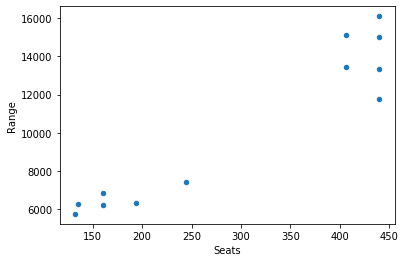

In [5]:
acDF.plot(kind="scatter",x="Seats",y="Range")

In [6]:
acDF

,Aircraft,Seats,Range,Category
0,A220-100,135.0,6279.0,Small
1,A220-300,160.0,6204.0,Small
2,A318,132.0,5750.0,Small
3,A319neo,160.0,6850.0,Small
4,A320neo,194.0,6300.0,Medium
5,A321neo,244.0,7400.0,Medium
6,A330-200,406.0,13450.0,Medium
7,A330-300,440.0,11750.0,Medium
8,A330-800,406.0,15094.0,Medium
9,A330-900,440.0,13334.0,Medium


In [62]:
engineSuppList = ["RTX", "GE", "RR.L", "SAF.PA" ]

In [63]:
customList = ["0753.HK",# air china
              "CEA", # China eastern airline
              "ZNH", # China southern airline
              "0293.HK", # Caythay pacific
              "THYAO.IS",#Tukish airline
              "DAL",#delta airlines
              "003490.KS", #Korean airline
              "AAL",# american airline gorup
              "THAI.BK",#thai airline
              "IAG.L",#international airlin egroup BA, one world////
              "AER" # aerCap
             ]

In [64]:
class stock():
    def __init__(self, yticker):
        self.yticker = yticker
    
    def load_rawdata(self):
        return yf.Ticker(self.yticker).history(period="max")
    
    def load_data(self):
        newdata = self.load_rawdata()
        newdata["Mean"] = (newdata["Open"]+newdata["High"]+newdata["Low"]+newdata["Close"])/4
        newdata["Volatility"] = (newdata["High"]-newdata["Low"])/newdata["Mean"]
        newdata["Momentum"] = (newdata["Close"]-newdata["Open"])/newdata["Mean"]
        return newdata

In [65]:
peerlist = np.concatenate((["AIR.PA"],engineSuppList,customList))

In [66]:
stockdata = []
for i in peerlist:
    temp=stock(i)
    stockdata.append(temp.load_data())

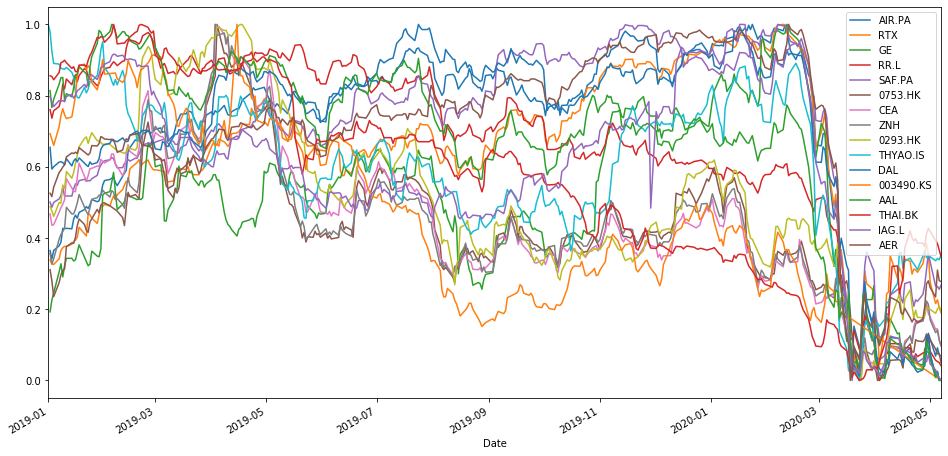

In [67]:
fig, ax = plt.subplots(figsize=(16,8))
for i in range(len(peerlist)):
    ((stockdata[i]["2019":]-stockdata[i]["2019":]["Mean"].min())/(stockdata[i]["2019":]["Mean"].max()-stockdata[i]["2019":]["Mean"].min())).plot(y="Mean",ax=ax)
ax.legend(peerlist)

In [68]:
allData = pd.concat([stockdata[i]["Mean"].to_frame() for i in range(len(peerlist))], axis=1, sort=False)
allData.columns = peerlist
allData=allData.dropna()

In [69]:
peerlist[0]

'AIR.PA'

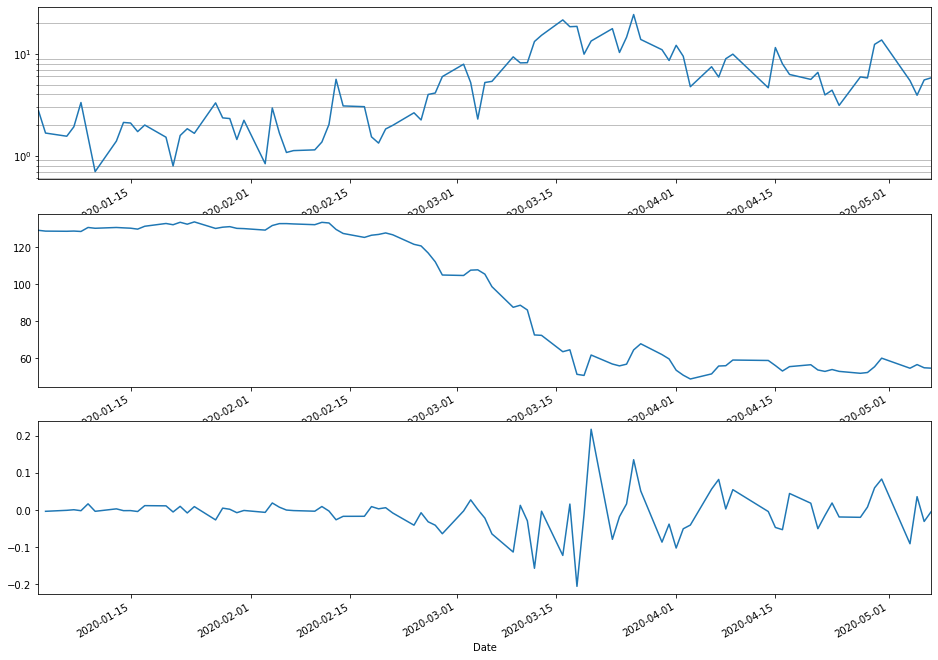

In [70]:
fig, ax =plt.subplots(nrows=3,figsize=(16,12))
(stockdata[0]["Volatility"]["2020":]*100).plot(logy=True,ax=ax[0])
ax[0].grid(which="minor")
(stockdata[0]["Mean"]["2020":]).plot(ax=ax[1])
ax[1].grid(which="minor")
(stockdata[0]["Mean"]["2020":].pct_change()).plot(ax=ax[2])
ax[2].grid(which="minor")

# Scratch paper for investing

This notebook is to understand some basic concept in investment and porfolio management.

## Drop dripping

The idea of drop dripping is to invest in smaller portions into an instrument not at the same time but at different times. This will reduce risk and minimise the market fluctuation.<br>

I want to understand and quantify this.

This are some initial comments:
- Form the time, when individual portions overlap, there is no more effect.

I want to estimate the effective price difference: <br>
$\Delta p = \sum^{f}_{i=0} (p(t_f)-p(t_i)) = f\cdot p(t_f) - \sum^{f}_{i=0} p(t_i)$<br>
where $t_i$ is the time when an investment is paid in. <br>

What this means is, that we always want to keep $\Delta p > 0$

In [59]:
def dprice(tstart, tend, nrInvest, pricefct):
    dt = int((tend - tstart)/nrInvest)
    part1 = nrInvest*pricefct(tstart+nrInvest*dt)
    part2 = sum([pricefct(tstart+i*dt) for i in range(nrInvest+1)])
    return (part1-part2)/part2

Example:<br>
Say we use a quadratic curve for testing.

In [133]:
def priceFct(t):
    return np.exp(t/10)*500*np.sin(t/20)**2*(t)**2+1000

In [134]:
priceFct(0)

1000.0

4.3426294089486595

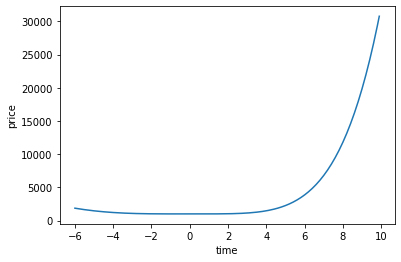

In [136]:
xdata = np.arange(-6,10,0.1)
ydata = priceFct(xdata)
plt.plot(xdata, ydata)
plt.xlabel("time")
plt.ylabel("price")
dprice(-40, 40,6, priceFct)

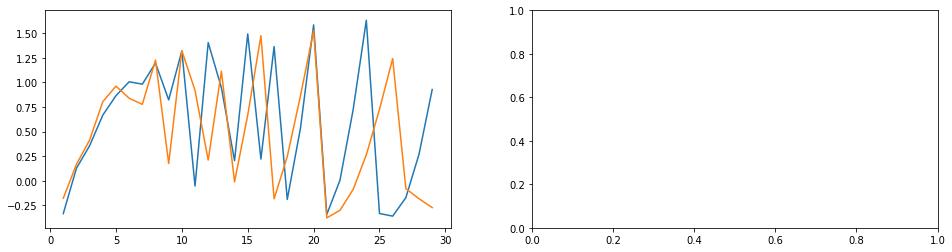

In [95]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,4))
nrInv = 30
tfinal =80
ax[0].plot(np.arange(1,nrInv),[dprice(-40, tfinal,i, priceFct) for i in np.arange(1,nrInv)])
ax[0].plot(np.arange(1,nrInv),[dprice(0, tfinal,i, priceFct) for i in np.arange(1,nrInv)])
#ax[0].plot(np.arange(1,nrInv),[nrInv*(((priceFct(80) - priceFct(0))/priceFct(0))) for i in 
#                               np.arange(1,nrInv)])